In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc4 as pm

import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow.keras.backend import sum as tf_sum

import seaborn as sns
import time

In [2]:
d = 4
lkj = tfp.distributions.LKJ(d,tf.cast(1,np.float64))
print(lkj.sample(2))

lkj

tf.Tensor(
[[[ 1.         -0.87216231  0.55307696  0.09310222]
  [-0.87216231  1.         -0.25968448  0.16597938]
  [ 0.55307696 -0.25968448  1.         -0.0356196 ]
  [ 0.09310222  0.16597938 -0.0356196   1.        ]]

 [[ 1.         -0.19337866 -0.18667736  0.61684973]
  [-0.19337866  1.         -0.29090003 -0.17726061]
  [-0.18667736 -0.29090003  1.          0.1576543 ]
  [ 0.61684973 -0.17726061  0.1576543   1.        ]]], shape=(2, 4, 4), dtype=float64)


<tfp.distributions.LKJ 'LKJ_LKJ' batch_shape=[] event_shape=[4, 4] dtype=float64>

In [133]:
# Generate Test Matrix
def TestMatrix():
    d0 = tfp.distributions.LogNormal(tf.math.log(tf.cast(1,tf.float64)),.1).sample(4)
    d1 = tfp.distributions.LogNormal(tf.math.log(tf.cast(.5,tf.float64)),.1).sample(4)
    d2 = tfp.distributions.LogNormal(tf.math.log(tf.cast(.25,tf.float64)),.1).sample(2)
    d2 = tf.stack([d2,d2])
    
    eye = tf.eye(4,dtype=np.float64)*d0
    upper = tf.roll(tf.eye(4,dtype=tf.float64),1,axis=1)*tf.reshape(d1,[4,1])
    lower = tf.roll(tf.eye(4,dtype=tf.float64),1,axis=0)*tf.reshape(d1,[1,4])
    outer = tf.roll(tf.eye(4,dtype=tf.float64),2,axis=0)*tf.reshape(d2,[1,4])
    
    full = eye+upper+lower+outer
    p = tf.einsum("ij,jk,jl->il",tf.eye(4,dtype=full.dtype),full,tf.eye(4,dtype=full.dtype))
    f = tf_sum(p)/4.
    
    print("full\n",full)
    print(p)
    
    return full/f

#@tf.function
def ApplyR_t(c,r):
    """ Calculate R * C * R"""
    c = tf.cast(c,r.dtype)
    rsqrt = tf.math.sqrt(r)
    rsqrt_d = tf.einsum("ij,ni->nij",tf.eye(r.shape[1],dtype=r.dtype),rsqrt)
    return tf.einsum("nij,jk,nkl->nil",rsqrt_d,c,rsqrt_d)

I_0 = tf.cast([3,2,1,.5],np.float64)
I_0 = I_0 / tf_sum(I_0)
R_0 = tf.cast([3,.9,.9,.9],np.float64)

print("I_0",I_0.numpy())
print("R_0",R_0.numpy())

m = TestMatrix()
print("m\n",m)

r_diag = tf.reshape(R_0,[1,R_0.shape[0]]) # fake multiple countries
print(r_diag)
I_1 = ApplyR_t(m, r_diag) * I_0

print(I_1)
print("sum = %.4f from %.4f pop * %.4f mean R_0"%(tf_sum(I_1).numpy(),np.sum(I_0),np.sum(R_0)/4.))

I_0 [0.46153846 0.30769231 0.15384615 0.07692308]
R_0 [3.         0.89999998 0.89999998 0.89999998]
full
 tf.Tensor(
[[0.96414964 0.49314833 0.28008398 0.43966852]
 [0.49314833 1.10157352 0.50883897 0.22767896]
 [0.28008398 0.50883897 1.13053321 0.55297363]
 [0.43966852 0.22767896 0.55297363 1.084814  ]], shape=(4, 4), dtype=float64)
tf.Tensor(
[[2.17705046 0.         0.         0.        ]
 [0.         2.33123979 0.         0.        ]
 [0.         0.         2.47242979 0.        ]
 [0.         0.         0.         2.30513511]], shape=(4, 4), dtype=float64)
m
 tf.Tensor(
[[0.4153197  0.2124299  0.12064973 0.1893928 ]
 [0.2124299  0.47451678 0.21918885 0.0980756 ]
 [0.12064973 0.21918885 0.48699153 0.23820041]
 [0.1893928  0.0980756  0.23820041 0.4672974 ]], shape=(4, 4), dtype=float64)
tf.Tensor([[3.         0.89999998 0.89999998 0.89999998]], shape=(1, 4), dtype=float64)
tf.Tensor(
[[[0.57505804 0.10740245 0.03049965 0.02393878]
  [0.16110367 0.13140464 0.03034922 0.00678985]
  [0.0

In [134]:
R_t = tfp.distributions.LogNormal(loc=tf.math.log(tf.cast([1.]*4,tf.float64)),scale=.1).sample(1000)
d = ApplyR_t(m,R_t)

print(d.shape)
print(R_t.shape)

(1000, 4, 4)
(1000, 4)


In [137]:
@pm.model
def simpleLKJ(r_t,data):
    r_t = tf.cast(r_t,tf.float32)
    data = tf.cast(data,tf.float32)
    
    lkj = yield pm.LKJ(
        dimension = 4,
        concentration = tf.cast(2.,tf.float32), # fails for float64.
        sd_dist= tf.cast(1.,tf.float64),
        name = "LKJ"
    )
    # "normalize" i.e. |1*lkj*1 * v| = |v|  
    p = tf.einsum("ij,jk,jl->il",tf.eye(4,dtype=lkj.dtype),lkj,tf.eye(4,dtype=lkj.dtype))
    f = tf_sum(p)/4.
    lkj_n = lkj/f
    
    
    estimate = ApplyR_t(lkj_n, r_t)
    C = yield pm.Deterministic("C",lkj_n)
    
    scale = tf.constant(.1,dtype=lkj_n.dtype)
    like = yield pm.Normal(loc=estimate,scale=scale,name="like",observed=data)
    
%time trace = pm.sample(simpleLKJ(R_t,d),num_samples=50,burn_in=500,num_chains=8)

# Some collected timings:
# - obs: 400 , samples: 200+100 @ 16 chains, no optimization tried --> 3:38 (6:33 sys), wrong. index error
# - obs: 1000, samples: 50+500 @ 8 : 2:41 (8:30 sys), matches 1e-4


CPU times: user 8min 30s, sys: 1min 14s, total: 9min 45s
Wall time: 2min 41s


In [111]:
trace.posterior

<xarray.Dataset>
Dimensions:              (chain: 4, draw: 10, simpleLKJ/C_dim_0: 4, simpleLKJ/C_dim_1: 4, simpleLKJ/LKJ_dim_0: 4, simpleLKJ/LKJ_dim_1: 4)
Coordinates:
  * chain                (chain) int64 0 1 2 3
  * draw                 (draw) int64 0 1 2 3 4 5 6 7 8 9
  * simpleLKJ/LKJ_dim_0  (simpleLKJ/LKJ_dim_0) int64 0 1 2 3
  * simpleLKJ/LKJ_dim_1  (simpleLKJ/LKJ_dim_1) int64 0 1 2 3
  * simpleLKJ/C_dim_0    (simpleLKJ/C_dim_0) int64 0 1 2 3
  * simpleLKJ/C_dim_1    (simpleLKJ/C_dim_1) int64 0 1 2 3
Data variables:
    simpleLKJ/LKJ        (chain, draw, simpleLKJ/LKJ_dim_0, simpleLKJ/LKJ_dim_1) float32 -46.404297 ... 275.02484
    simpleLKJ/C          (chain, draw, simpleLKJ/C_dim_0, simpleLKJ/C_dim_1) float32 -0.14586574 ... 0.5216023
Attributes:
    created_at:     2020-07-15T22:08:21.735037
    arviz_version:  0.9.0

[[0.41552603 0.21256681 0.12012021 0.18948986]
 [0.2116544  0.4750355  0.2192815  0.09825107]
 [0.12157315 0.21917562 0.4874821  0.23797472]
 [0.18905014 0.09849739 0.23763934 0.46668229]]
tf.Tensor(
[[0.4153197  0.2124299  0.12064973 0.1893928 ]
 [0.2124299  0.47451678 0.21918885 0.0980756 ]
 [0.12064973 0.21918885 0.48699153 0.23820041]
 [0.1893928  0.0980756  0.23820041 0.4672974 ]], shape=(4, 4), dtype=float64)
tf.Tensor(
[[ 2.06334715e-04  1.36903667e-04 -5.29516403e-04  9.70600249e-05]
 [-7.75509334e-04  5.18707385e-04  9.26464982e-05  1.75463749e-04]
 [ 9.23421320e-04 -1.32262521e-05  4.90567764e-04 -2.25693125e-04]
 [-3.42658341e-04  4.21787394e-04 -5.61073560e-04 -6.15118645e-04]], shape=(4, 4), dtype=float64)


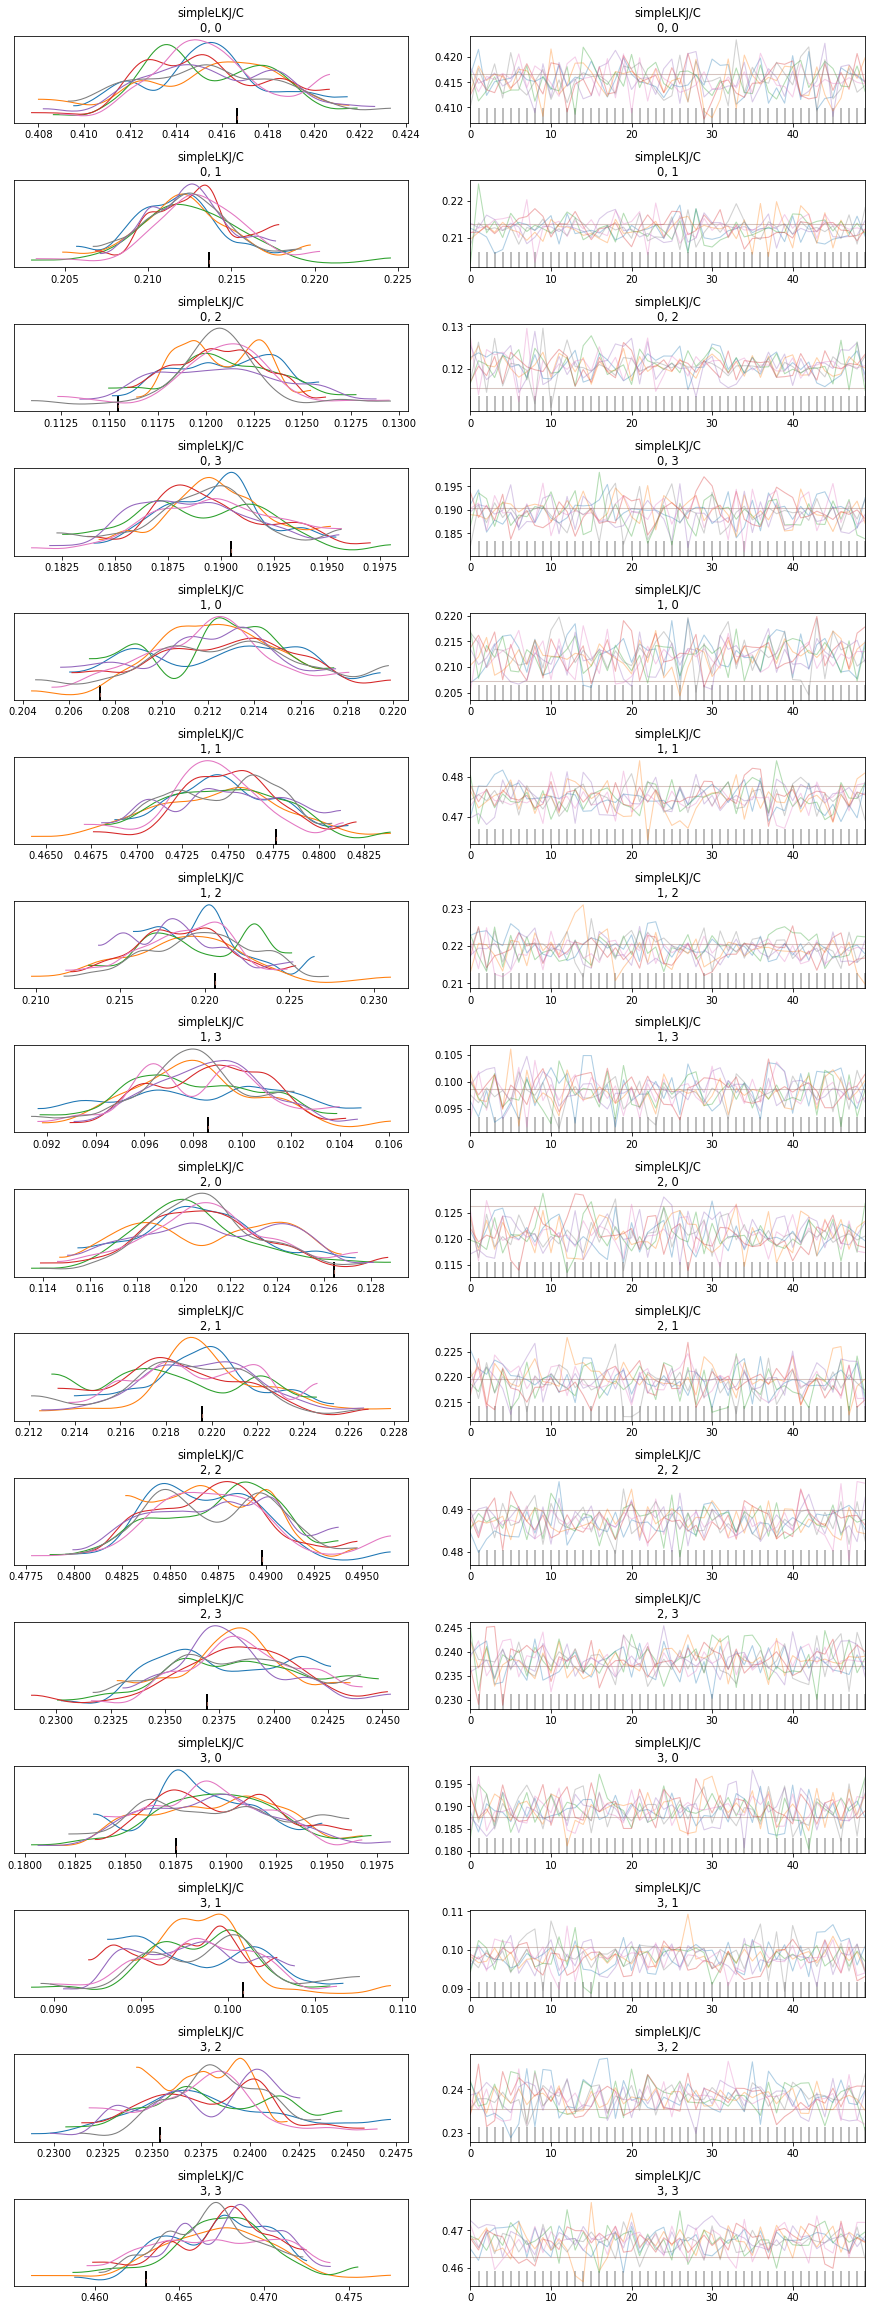

In [138]:
m_est = np.mean(trace.posterior["simpleLKJ/C"].data,(0,1))
print(m_est)
print(m)
print(m_est-m)
_ = az.plot_trace(trace,var_names=["simpleLKJ/C"])